# In Depth: Linear Regression
Just as naive Bayes is a good starting point for classification tasks, linear regression models are a good starting point for regression tasks. They are popular because they can be fit very quickly, and are very interpretable.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Simple Linear Regression
The most familiar linear regression is a straight-line fit to data in the form of **y = ax + b** where **a** is the slope and **b** is the y-intercept. Consider the following data:

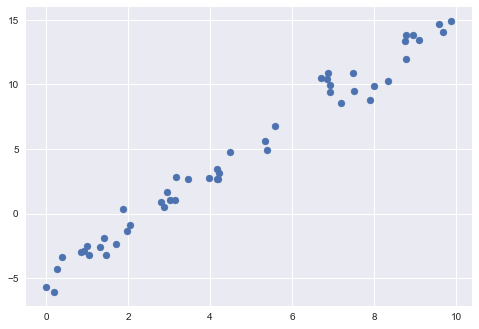

In [3]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

In [4]:
# fit data and contruct best-fit line
from sklearn.linear_model import LinearRegression

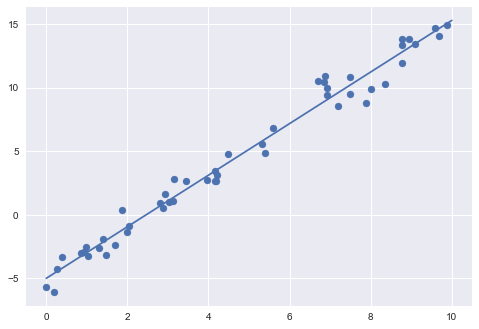

In [5]:
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 100)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x,y)
plt.plot(xfit, yfit);

In [6]:
print "Model slope: ", model.coef_[0]
print "Model intercept: ", model.intercept_

Model slope:  2.02720881036
Model intercept:  -4.99857708555


The `LinearRegression` estimator is much more capable than this, however - in addition to simple straight-line fits, it can also handle multidimensional linear models of the form:

$y = a_0 + a_1x_1 + a_2x_2 + ...$

where there are multiple x values. Geometrically, this is akin to fitting a plane to three points in three dimensions, or fitting a hyper-plane to points in higher dimensions. These multidimensions are hard to visualize, but we can see one of these fits in action by building some example data, using NumPy's matrix multiplication operator:

In [7]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])

model.fit(X, y)
print model.intercept_
print model.coef_

0.5
[ 1.5 -2.   1. ]


## Basis Function Regression
One trick to adapt linear regression to nonlinear relationships between variables is to transform the data according to *basis functions*. The idea is to take our multidimensional linear model:

$y = a_0 + a_1x_1 + a_2x_2 + a_3x_3 + ...$

and build the $x_1,x_2,x_3$, and so on from our single-dimensional input x. That is, we let $x_n = f_n(x)$, where $f_n()$ is some function that transforms our data.

For example, if $f_n(x) = x^n$, our model becomes a polynomial regression:

$y = a_0 + a_1x + a_2x^2 + a_3x^3 + ...$

Notice that this is still a linear model - the linearity refers to the fact that the coefficients $a_n$ never multiply or divide each other. What we have effectively done is taken our one-dimensional x values and projected them into a higher dimension, so that a linear fit can fit more complicated relationships between x and y.

#### Polynomial basis functions

In [8]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[  2.,   4.,   8.],
       [  3.,   9.,  27.],
       [  4.,  16.,  64.]])

The transformer has converted our one-dimensional array into a three-dimensional array by taking the exponent of each value. This new higher-dimensional data representation can be plugged into a linear regression. Let's use a pipeline to make a 7th-degree polynomial model:

In [9]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

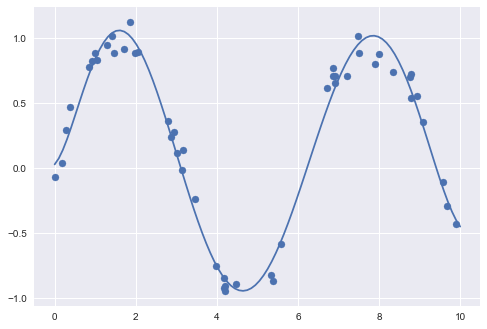

In [10]:
# fit a sine wave with noise
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

Our linear model, through the use of 7th-order polynomial basis functions, can provide an excellent fit to this nonlinear data!

#### Gaussian basis functions

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
        
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
    
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
    
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_, self.width_, axis=1)

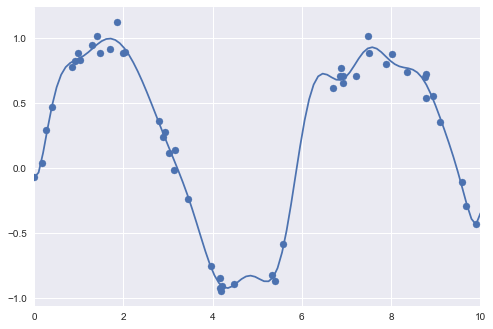

In [12]:
gauss_model = make_pipeline(GaussianFeatures(20), LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);

## Regularization

The introduction of basis functions into our linear regression makes the model much more flexible, but it also can very quickly lead to overfitting. For example, if we choose too many Gaussian basis functions, we end up with results that don't look so good:

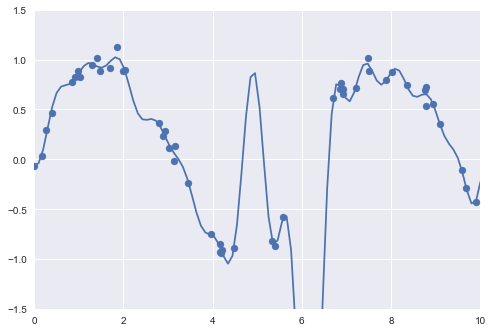

In [13]:
model = make_pipeline(GaussianFeatures(30),
                      LinearRegression())
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))
plt.xlim(0,10)
plt.ylim(-1.5, 1.5);

With the data projected to the 30-dimensional basis, the model has far too much flexibility and goes to extreme values between locations where it is contrained by data. We can see the reason for this if we plot the coefficients of the Gaussian bases with respect to their locations:

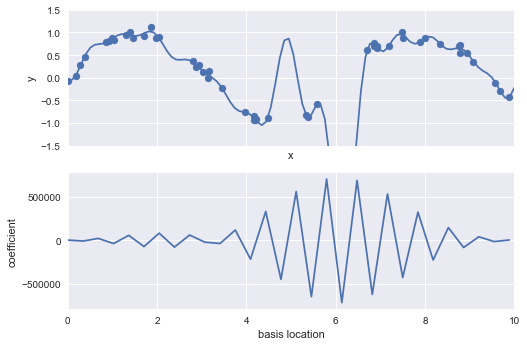

In [15]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)
        
    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))
    
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

The lower panel shows the amplitude of the basis function at each location. This is typical overfitting behavior when basis functions overlap: the coefficients of adjacent basis functions blow up and cancel each other out. It would be nice if we could limit such spikes explicitly in the model by penalizing large values of the model parameters. Such penalty is known as *regularization*.

#### Ridge regression ($L_2$ regularization)

The most common form of regularization is known as *ridge regression* or *$L_2$ regularization*. This proceeds by penalizing the sum of squares (2-norms) of the model coefficients; in this case, the penalty on the model fit would be:

$P = \alpha\Sigma^{N}_{n = 1}\theta^{2}_{n}$

where $\alpha$ is a free parameter that controls the strength of the penalty. This type of penalized model is built into Scikit-Learn with the `Ridge` estimator:

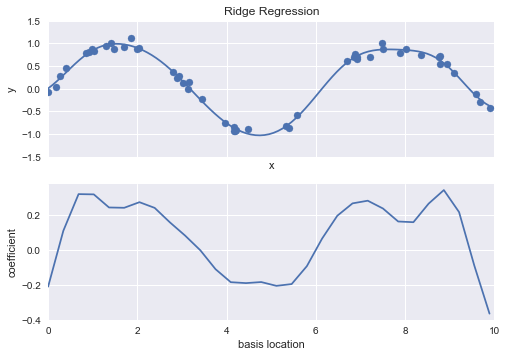

In [16]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')

The $\alpha$ parameter is essentially a knob controlling the complexity of the resulting model. In the limit $\alpha\rightarrow 0$, we recover the standard linear regression result; in the limit $\alpha\rightarrow\infty$, all model responses will be suppressed. One advantage of ridge regression in particular is that it can be computed very efficiently - at hardly more computational cost than the original linear regression model.

#### Lasso regularization ($L_1$)
Another very common type of regularization is known as **lasso**, and involves penalizing the sum of absolute values (1-norms) of regression coefficients:

$P = \alpha\Sigma^{N}_{n=1}|\theta_n|$

Though similar to ridge regression, the results can differ surprisingly. Due to geometric reasons, lasso regression tends to favor sparse models where possible. It preferentially sets model coefficents to zero, effectively eliminating unimportant features of a dataset.

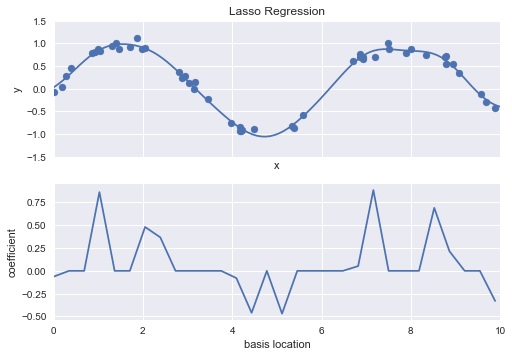

In [18]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))
basis_plot(model, title='Lasso Regression');

With the lasso regression penalty, the majority of coefficents are zero, with the functional behavior being modeled by a small subset of data features. Similar to ridge regularization, the $\alpha$ parameter tunes the strength of the penalty.

## Example: Predicting Bicycle Traffic
In this example, we will join bike traffic data from Seattle with another dataset, and try to determine the extent to which weather and seasonal factors - temperature, precipitation, and daylight hours - affect the volume of bike traffic. 

In [20]:
# load datasets
import pandas as pd
counts = pd.read_csv('data/FremontHourly.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('data/BicycleWeather.csv', index_col='DATE', parse_dates=True)

In [21]:
counts.head()

,Fremont Bridge NB,Fremont Bridge SB
Date,,
2012-10-02 00:00:00,0.0,0.0
2012-10-02 01:00:00,0.0,0.0
2012-10-02 02:00:00,0.0,0.0
2012-10-02 03:00:00,0.0,0.0
2012-10-02 04:00:00,0.0,0.0


In [22]:
weather.head()

,STATION,STATION_NAME,PRCP,SNWD,SNOW,TMAX,TMIN,AWND,WDF2,WDF5,...,WT17,WT05,WT02,WT22,WT04,WT13,WT16,WT08,WT18,WT03
DATE,,,,,,,,,,,,,,,,,,,,,
2012-01-01,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0,0,0,128,50,47,100,90,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
2012-01-02,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,109,0,0,106,28,45,180,200,...,-9999,-9999,-9999,-9999,-9999,1,1,-9999,-9999,-9999
2012-01-03,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,8,0,0,117,72,23,180,170,...,-9999,-9999,-9999,-9999,-9999,-9999,1,-9999,-9999,-9999
2012-01-04,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,203,0,0,122,56,47,180,190,...,-9999,-9999,-9999,-9999,-9999,1,1,-9999,-9999,-9999
2012-01-05,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,13,0,0,89,28,61,200,220,...,-9999,-9999,-9999,-9999,-9999,-9999,1,-9999,-9999,-9999


In [23]:
# compute daily bike traffic
daily = counts.resample('d', how='sum')
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

/Volumes/RobStorage/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  


In [24]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [25]:
# add indicator of holiday
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

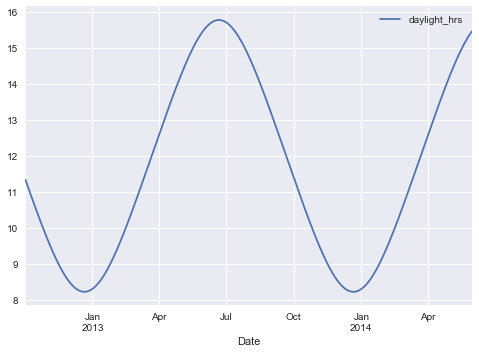

In [26]:
# add hours of daylight for each day
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot();

In [34]:
# add average temperature and total precipitation to data
# also flag whether day was dry
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day
Date,,,,,,,,,,,,,
2012-10-02,1938.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,11.335681,0.0,13.90,1
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1


In [35]:
# add counter that increases from day 1 & measures years
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [36]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-02,1938.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,11.335681,0.0,13.90,1,0.000000
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1,0.002740
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1,0.005479
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1,0.008219
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1,0.010959


In [40]:
# Choose columns to use & fit linear regression model
column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

# set fit_intercept=False because daily flags act as their own intercepts
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

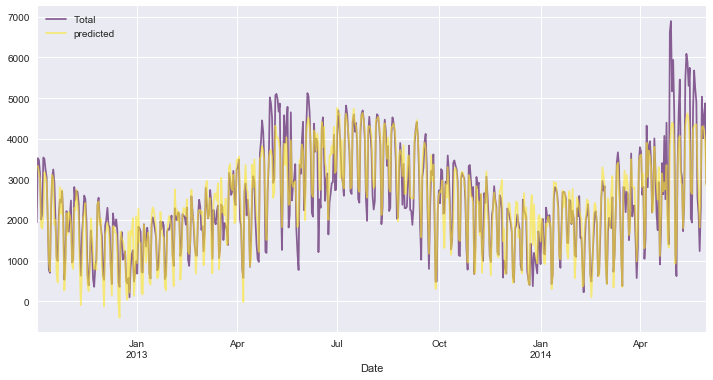

In [54]:
# compare the total and predicted
daily[['Total', 'predicted']].plot(alpha=0.6, figsize=(12,6), colormap='viridis');

It looks like our predictions did fairly well, but struggled during summer months. Let's take a look at the coefficients of the linear model to estimate how much each feature contributes to the daily bicycle count:

In [55]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon              265.779104
Tue              306.551668
Wed              359.247220
Thu              199.486334
Fri              -93.133822
Sat            -1276.752727
Sun            -1308.178141
holiday        -1190.062935
daylight_hrs     137.183312
PRCP            -662.551672
dry day          558.729470
Temp (C)          64.596364
annual           210.767214
dtype: float64

These numbers are difficult to interpret without some measure of their uncertainty. Let's use the bootstrap resamplings of the data to compute the uncertainties.

In [56]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_ for i in range(1000)], 0)

In [58]:
# let's look at results with estimated errors
print pd.DataFrame({'effect': params.round(0), 'error': err.round(0)})

              effect  error
Mon            266.0  128.0
Tue            307.0  128.0
Wed            359.0  124.0
Thu            199.0  127.0
Fri            -93.0  115.0
Sat          -1277.0  128.0
Sun          -1308.0  129.0
holiday      -1190.0  196.0
daylight_hrs   137.0   14.0
PRCP          -663.0   70.0
dry day        559.0   44.0
Temp (C)        65.0    5.0
annual         211.0   47.0


We first see a relatively stable trend in the weekly baseline:
 - There are more riders on weekdays than on weekends and holidays. 
 - For each additional hour of daylight, 137 +/- 14 more people choose to ride
 - A temperature increase of one degree Celsius encourages 65 +/- 5 people to go for a ride
 - A dry day means an average of 559 +/- 44 more riders.
 - Each inch of precipitation means 663 +/- 70 people avoid riding their bikes.
 - All effects accounted for, we see an increase of 211 +/- 47 new daily riders each year.
 
The downside of this model is that it is almost certainly missing some relevant information. For example, non-linear effects (such as effects of precipitation *and* cold temperature) and nonlinear trends within each variable (such as disinclination to ride at very cold and very hot temps) cannot be accounted for in this model. In addition, we have thrown away some extra information (such as the difference between a rainy morning and a rainy afternoon), and we have ignored correlations between days (such as the possible effect of a rainy Tuesday on Wednesday's numbers, or the effect of an unexpected sunny day after a streak of rainy days). These are all potentially interesting effects, and we now have the tools to begin exploring them!